# StackOverflow Tags Prediction without specific ML packagess



Tag dataset contins with titles and labled tags of StackOwerflow questions.

<br> Data set is provided by Kaggle form [`Kaggle Questions csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Questions.csv)  and [`Kaggle Labled Tags csv file`](https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input?select=Tags.csv)
we'll try to implement three aproches (Bag Of Words, TF-IDF and Continues Bag Of Words) to get an embeddings of words and use them for logistic regression model.

<br> Since the predicted lable for each observation might have more then one true value, this become the multilable classification task. And for solving we need to train N seperate classifiers, where N is the number of unique possible tags from train set.

<br> At the end, after learning process we'll explore the trained weights in order to estimate the most and the least important for predicting the given tag.

<br> For this implementation all needed classes, methods and function is written in corresponding files and will be invoke during the process.


# Outline
- [ 1 - Import Data](#1)
- [ 2 - Exploring and preparing data for model](#2)
  - [ 2.1 - Bag of words](#2.1)
  - [ 2.2 - TF-IDF](#2.2)
  - [ 2.3 - CBOW](#2.3)
    - [ 2.3.1 - Data preparation](#2.3.1)
    - [ 2.3.2 - Train neuron network and transform train/test data](#2.3.2)
    - [ 2.3.3 - PCA for plotting results](#2.3.3)
- [ 3 - Training models](#3)
    - [ 3.1 - BOW evaluation](#3.1)
    - [ 3.2 - Tfidf evaluation](#3.2)
    - [ 3.3 - CBOW evaluation](#3.3)
- [ 4 - Most important features](#4) 
    

<a name="1"></a>
## 1 - Import Data

In [6]:
import numpy as np
import pandas as pd
from scipy import sparse as sp_sparse
import re
%matplotlib inline
import matplotlib.pyplot as plt

from ast import literal_eval

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sergeiakhmadulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
train = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Questions.csv/Questions.csv',\
                    encoding = "ISO-8859-1", nrows=100000,index_col=False)

In [8]:
y_data = pd.read_csv('/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/Tags.csv/Tags_1.csv',\
                     encoding = "ISO-8859-1",index_col=False)

In [9]:
all_data = pd.concat([train, y_data], axis=1)

<a name="2"></a>
## 2 - Exploring and preparing data for model

In [7]:
all_data.head()

,title,tags
0,How to draw a stacked dotplot in R?,['r']
1,mysql select all records where a datetime fiel...,"['php', 'mysql']"
2,How to terminate windows phone 8.1 app,['c#']
3,get current time in a specific country via jquery,"['javascript', 'jquery']"
4,Configuring Tomcat to Use SSL,['java']


In [8]:
len(all_data)

100000

In [10]:
all_data['tags'] = all_data['tags'].apply(literal_eval)

In [11]:
def most_common_words(text):
    """
    Function that calculate the count of appearance of each unique word

    Parameters:
    text: text where to calculate apearance

    Outputs:
    words_count: count of appearance of each word in labeles
    """
    words_counts = {}

    for i in text:
        try:
            for j in i.split():
                words_counts[j] = words_counts.get(j, 0) + 1
        except:
            for j in i:
                words_counts[j] = words_counts.get(j, 0) + 1
    return words_counts

words_counts = most_common_words(all_data["tags"])
words_counts = dict(sorted(words_counts.items(), key=lambda x: x[1], reverse=True))

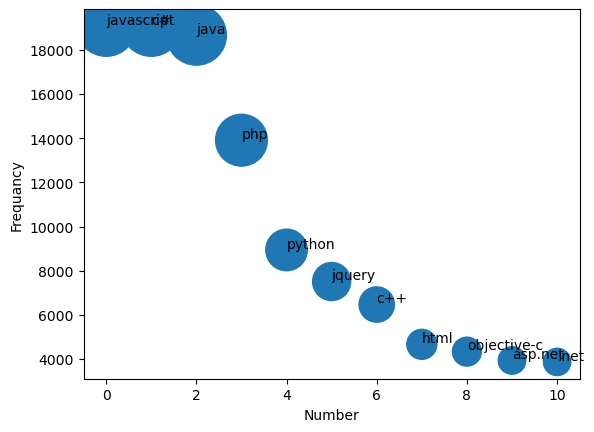

In [12]:
max_words = 11
x = range(max_words)
y = list(words_counts.values())[:max_words]
z = [i/10 for i in list(words_counts.values())[:max_words]]

fig, ax = plt.subplots()

ax.set_xlabel("Number")
ax.set_ylabel("Frequancy")
    
ax.scatter(x, y, s=z)

for i, txt in enumerate(list(words_counts.keys())[:max_words]):
    ax.annotate(txt, (x[i], y[i]+100))


plt.show()

In [13]:
def train_test_splitting(X, y, test_size, shuffle=True):
    """
    Function that makes train test splitting of whole corpuse of texts

    Parameters:
    X: corpus of texts
    y: tags for coresponding title
    test_size: ratio of test part
    shuffle: flag indicator for shuffle the data before splitting

    Outputs:
    data with labels for train
    data with labels for test
    """
    length_data = len(X)
    test_len = int(length_data*test_size)
    train_len = length_data - test_len
    if shuffle:
        index = np.random.permutation(length_data)
    else:
        index = np.arange(length_data)
    train_index = index[:train_len]
    test_index = index[train_len:]

    return X[train_index],X[test_index],y[train_index],y[test_index]

In [14]:
np.random.seed(0)
X_train,X_test,y_train,y_test = train_test_splitting(all_data["title"], all_data["tags"], test_size=0.3 , shuffle=True) 

In [15]:
def text_prepare(text):
    """
    Function that does a general text preparation

    Parameters:
    text: corpus of text documents

    Output:

    text without spetial characters, "stop words" and in lower case
    """
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower()

    text = REPLACE_BY_SPACE_RE.sub(r' ',text)
    text = BAD_SYMBOLS_RE.sub(r'',text)
    text = [w for w in text.split() if not w in STOPWORDS]
    
    return ' '.join(text)

In [16]:
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]

<a name="2.1"></a>
## 2.1 - Bag of words

A bag-of-words is a representation of text that describes the occurrence of words within a documents. It involves two steps:

1) vocabulary of known words.
2) measure of the presence of known words.

<div>
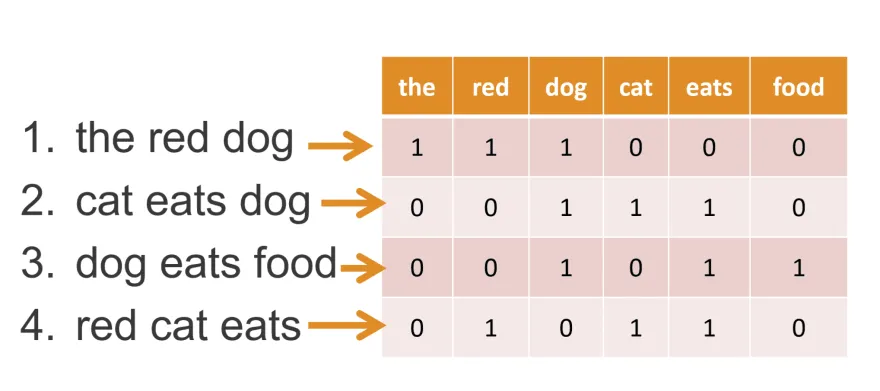
</div>

In [28]:
import Bagofwords as BOW

BagOW = BOW.BagOfWords(maximum_words = 5000)
BagOW.fit(X_train)
X_train_mybag = BagOW.transform(X_train)
X_test_mybag = BagOW.transform(X_test)
bag_of_words_dic = BagOW.get_vocab()

<a name="2.2"></a>
## 2.2 - TF-IDF

Term frequency-inverse document frequency (TF-IDF) measures the importance of a word to a specific document.
<br>It’s the product of two statistics: term frequency (TF) and inverse document frequency (IDF).


<div>
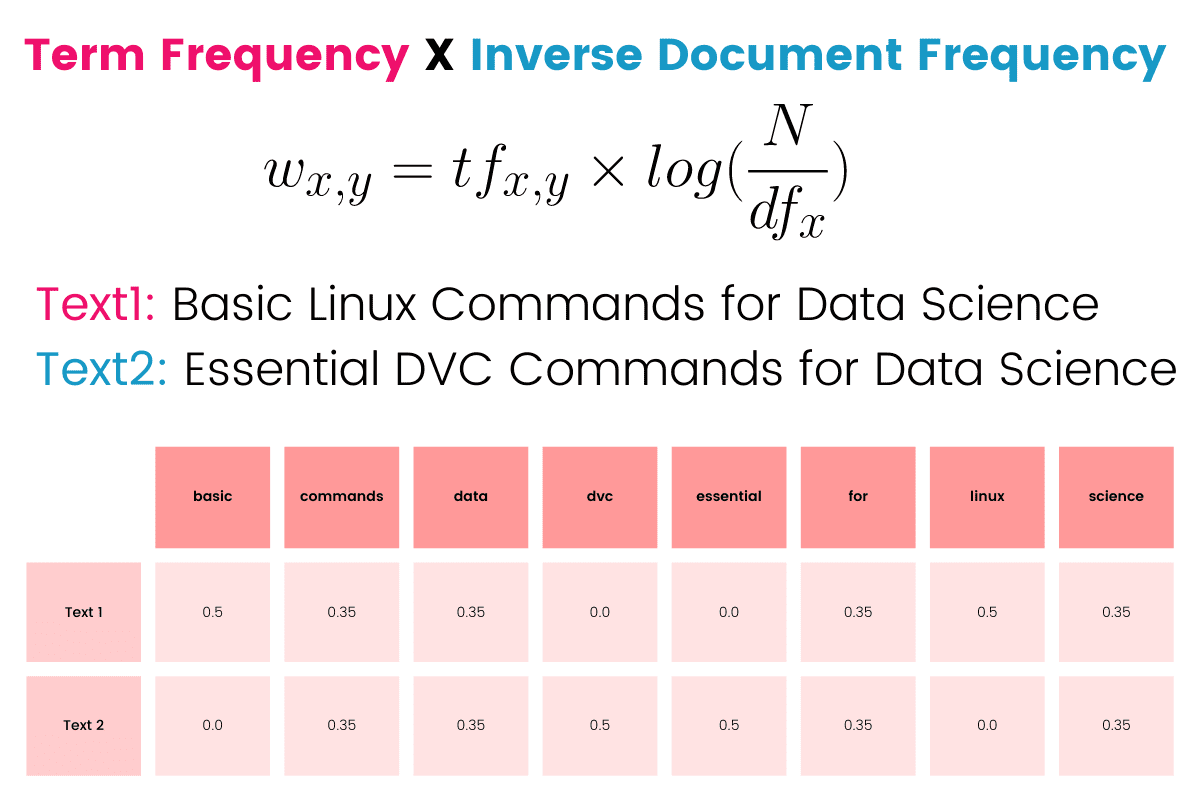
</div>

In [34]:
import Tfidf as tf

tfidf_obj = tf.TFIDF()
tfidf_obj.fit(X_train)

X_train_tfidf = tfidf_obj.transform(X_train)
X_test_tfidf = tfidf_obj.transform(X_test)
tfidf_vocab = tfidf_obj.get_vocab()

tfidf_index_to_word = {index:word for index,word in enumerate(tfidf_vocab)}

/Users/sergeiakhmadulin/My Drive/Simple NLP/Tfidf.py:55: RuntimeWarning: divide by zero encountered in divide
  norm_tfidf = tfidf.multiply(1/np.sqrt(np.sum(tfidf.power(2), axis = 1)).reshape((length_rows,1)))


<a name="2.3"></a>
## 2.3 - CBOW

CBOW is a neural network-based algorithm that predicts a target word given its surrounding context words. It is a type of “unsupervised” learning, meaning that it can learn from unlabeled data, and it is often used to pre-train word embeddings that can be used for various NLP tasks such as sentiment analysis, text classification, and machine translation. 
<br> The CBOW model uses the target word around the context word in order to predict it. Consider the below example “She is a great dancer”, having window size=2 we'll get 2 PAD tokens at the begining and end. And create pairs of context words and target words. The word pairings would appears like this: 
<div>
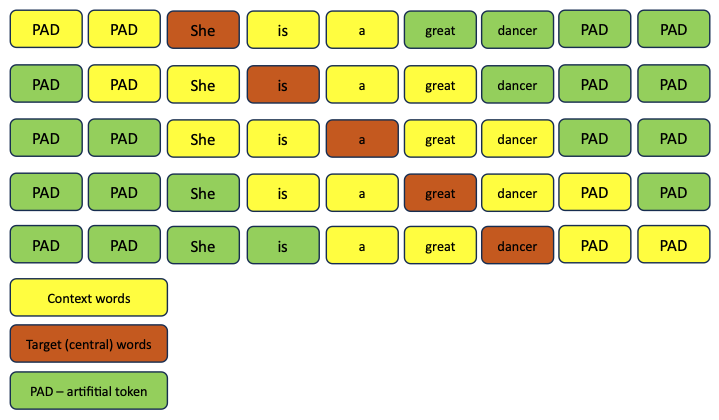
</div>

At the end of the first step we'll get two arrays:
1) one with context words 
2) and the second one with target (central) words
that is what we are going to feed into neuron network in order to train it with only 2 layers.
<br>As a result we'll get two matrises with trained weights and use eather first or second or avarege of them to train. 
Also at this step we will create two dictionaries to convert all unique words into a number and vise versa. 
<br>Hopefully words representation (embedings) in this matrix would be better aproximation of each word for classification model.

The concept is shown on the image below:

<div>
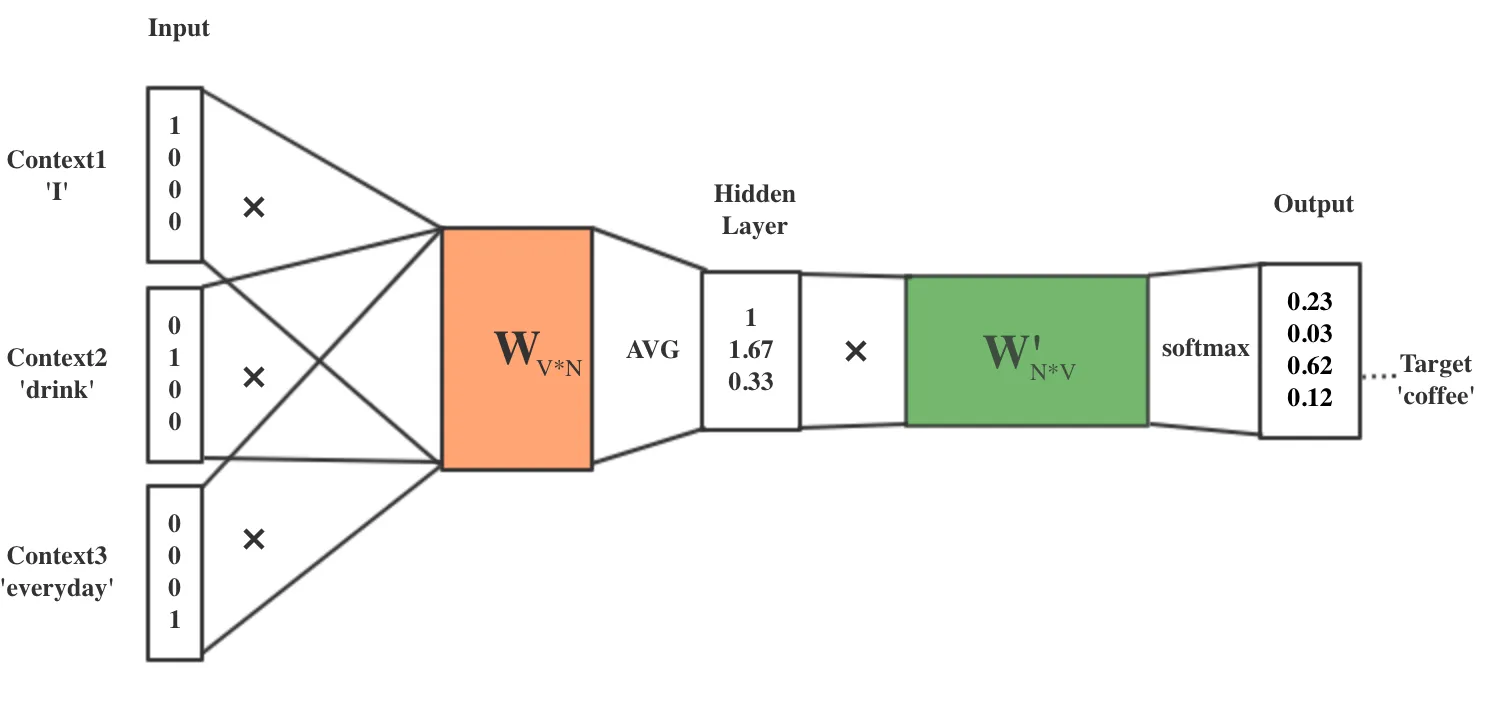
</div>

<a name="2.3.1"></a>
### 2.3.1 - Data preparation

In [17]:
def add_pad(text, num_of_padding, padding_character):
    """
    Function that create two dictionaries that allows to map each 
    word to corresponding number of column on embedding matrix and vise versa.

    Parameters:
    
    text: corpus of train text
    num_of_padding: number of characters that needs to be added (equels to window size)
    padding_character: character that is added at the beggining and end of sentense
    
    Outputs:
    text_with_pad - text with added token "padding_character"
    """
    text_with_pad = []
    for sent in text:
        sent = (padding_character + " ") * num_of_padding + sent + (" " + padding_character) * num_of_padding
        text_with_pad.append(sent)
    return text_with_pad

In [18]:
def get_dict(text):
    """
    Function that create two dictionaries that allows to map each 
    word to corresponding number of column on embedding matrix and vise versa.

    Parameters:
    
    text: corpus of train text

    Outputs:
    word2Ind - vocabulary that maps all words to numbers
    Ind2word - vocabulary that maps numbers to corresponding words
    """
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for sent in text:
        try:
            for word in sent.split():
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
        except:
            for word in sent:
                if word not in word2Ind.keys():
                    word2Ind[word] = idx
                    Ind2word[idx] = word
                    idx += 1
    return word2Ind,Ind2word

In [19]:
def get_data_with_window(text, num_neighbor_words, padding = False):
    """
    Function that create data to train with context words, target words with given window. Two dictionaries that allows to map each 
    word to corresponding number of column on embedding matrix and vise versa.

    Parameters:
    
    text: corpus of train text
    num_neighbor_words: number of context words around the target word
    padding: flag to create PAD words at the beginning and at the end of each oservation in order to whole words from sentense appears
    as target ti predict.

    
    Outputs: 
    X_matrix - matrix of embedding representation of words for train data
    y_matrix - matrix of embedding representation of words for train data
    word2Ind - vocabulary that maps all words to numbers
    Ind2word - vocabulary that maps numbers to corresponding words
    """
    if padding:
        text = add_pad(text, num_neighbor_words, "PAD")
        
    word2Ind, Ind2word = get_dict(text)
    vector_lenght = len(word2Ind)
    count = 0
    for sent in text:
        length = len(sent.split()) - 2*num_neighbor_words
        if length > 0:
            count += length
    X_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    y_matrix = sp_sparse.lil_matrix((count,vector_lenght))
    Y = []
    n = 0
    for row, sent in enumerate(text):
        sent_to_separete = sent.split()
        for i in range(num_neighbor_words, len(sent_to_separete) - num_neighbor_words):
            center_word = sent_to_separete[i]
            context_words = sent_to_separete[(i - num_neighbor_words):i] + sent_to_separete[(i+1):(i+num_neighbor_words+1)]
            
            y_matrix[n, word2Ind[center_word]] = 1
            Y.append(word2Ind[center_word])
            for con_word in context_words:
                X_matrix[n, word2Ind[con_word]] += 1
            n += 1
    X_matrix = (X_matrix/sp_sparse.lil_matrix.sum(X_matrix, axis = 1)).tolil()
    Y = np.array(Y)
    return X_matrix, y_matrix, word2Ind, Ind2word

In [21]:
X, y, word2Ind, Ind2word  = get_data_with_window(X_train, 2, padding = True)

<a name="2.3.2"></a>
### 2.3.2 - Train neuron network and transform train/test data

In [99]:
#Class for declaring neuron network object and training model
import NN_for_CBOW as NN

In [335]:
from importlib import reload
reload(NN)

<module 'NN_for_CBOW' from '/Users/sergeiakhmadulin/My Drive/Simple NLP/NN_for_CBOW.py'>

In [337]:
res, W_1,W_2 = NN.train_network(X, y, learning_rate = 1, hidden_neurons = 128, num_epoch = 5, batchsize = 32, initialization = "xavier")

done 25.2% of epoch - 0, loss: 6.334908484364909 
time for 100000 samples: 0:03:02.139597
done 50.5% of epoch - 0, loss: 9.487801831512321 
time for 100000 samples: 0:06:01.206355
done 75.7% of epoch - 0, loss: 5.416987453108742 
time for 100000 samples: 0:09:00.586726
done epoch: 0, loss: 10.863486802623637 
 weights saved
done 25.2% of epoch - 1, loss: 6.287556195151872 
time for 100000 samples: 0:03:03.970030
done 50.5% of epoch - 1, loss: 8.777134821829755 
time for 100000 samples: 0:13:03.359937
done 75.7% of epoch - 1, loss: 5.651972431286038 
time for 100000 samples: 0:52:39.282627
done epoch: 1, loss: 10.53540129391145 
 weights saved
done 25.2% of epoch - 2, loss: 6.457847947674838 
time for 100000 samples: 0:37:43.194238
done 50.5% of epoch - 2, loss: 8.367545486983728 
time for 100000 samples: 0:39:58.590892
done 75.7% of epoch - 2, loss: 5.744790591799935 
time for 100000 samples: 0:42:17.731443
done epoch: 2, loss: 9.661882345957142 
 weights saved
done 25.2% of epoch - 3,

In [ ]:
# Resume training code, with alredy updated weights

# res, W_1,W_2 = NN.train_network(X, y, hidden_neurons = 64, num_epoch = 6, batchsize = 100, \
#                                 initialization = "custom",weights_1 = W_1, weights_2 = W_2)

In [24]:
W_1 = np.array(pd.read_csv("weights_1.csv", header=None))
W_2 = np.array(pd.read_csv("weights_2.csv", header=None))

<a name="2.3.3"></a>
### 2.3.3 - PCA for plotting results

In [25]:
#import custom PCA class
import PCA as pca
pca_obj = pca.PCA()

In [27]:
all_embedings_for_model = W_2.T[1:]

In [28]:
Ind2word_no_pad = {k:v for k,v in enumerate(list(Ind2word.values())[1:])}
word2Ind_no_pad = {k:v for v,k in Ind2word_no_pad.items()}

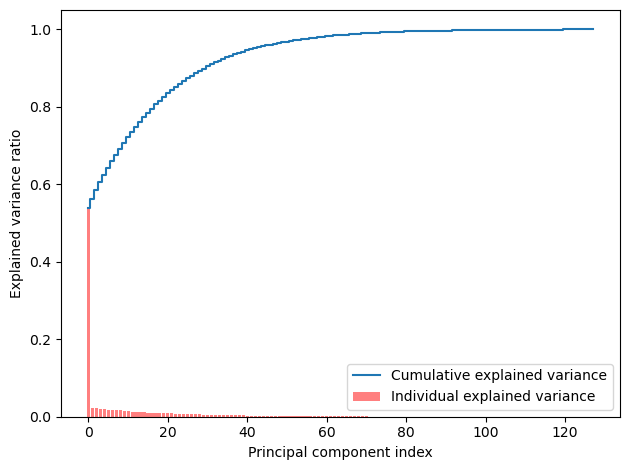

In [29]:
pca_obj.fit(all_embedings_for_model)
word_embedings_pca = pca_obj.pca_transform(all_embedings_for_model)
pca_obj.plot_explained_varience(all_embedings_for_model)

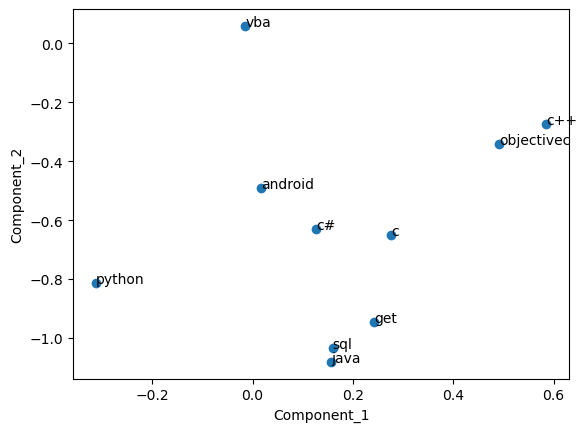

In [30]:
word_embedings_pca_2_comp = pca_obj.pca_transform(all_embedings_for_model, 2)
pca_obj.plot_some_data(word_embedings_pca_2_comp, word2Ind_no_pad, ['python','c','c++','c#','objectivec','sql','vba','get','java', 'android'])

In [31]:
embedings_means_for_model = np.mean(W_2.T[1:,:2],axis = 1)

In [32]:
def transform_to_vector(data_to_transform, word2num_dictionary, embeding_matrix):
    """
    Function for transorming train and test data with new matrix from CBOW model and replase words with corresponding embedings.

    Parameters:
    
    data_to_transform: corpuse of text document to transform
    word2num_dictionary: created dictionary that maps word with coresponding number of column
    embeding_matrix: matrix of word embeding from CBOW model

    Outputs:
    TF_matrix: matrix of word embedings of data
    """
    length_rows = len(data_to_transform)
    length_col = embeding_matrix.shape[0]
    TF_matrix = sp_sparse.lil_matrix((length_rows,length_col))
    for row,sent in enumerate(data_to_transform):
        for word in sent.split():
            if word in list(word2num_dictionary.keys()):
                num_of_word = word2num_dictionary.get(word,0)
                TF_matrix[row,num_of_word] = embeding_matrix[num_of_word]
    
    return TF_matrix

In [33]:
X_train_cbow = transform_to_vector(X_train, word2Ind_no_pad, embedings_means_for_model)
X_test_cbow = transform_to_vector(X_test, word2Ind_no_pad, embedings_means_for_model)

<a name="3"></a>
## 3 - Training models

In [34]:
#Import custom classes for binarization target variables and model parameters
import Binarizer as binar
import Logistic_Reg as LR

import Classification_report as CR

In [35]:
bnr = binar.Binarizer()
bnr.fit(y_train)
y_train_mat = bnr.transform(y_train)
y_test_mat = bnr.transform(y_test)
unique_classes = bnr.get_vocab()

In [36]:
lib = "/Users/sergeiakhmadulin/Library/CloudStorage/GoogleDrive-akhmadulinsergey@gmail.com/My Drive/Simple NLP/"

def train_model(model, model_name, x_train, y_train, x_test, batchsize = None, resume_training = False, save_results = True):
    """
    Function to train model. Takes train sampels, evaluetes weights, save them to folder in case of resuming training process
    and return test data predictions and trained weights

    Parameters:
        
    model: model object
    model_name: name of the model
    x_train: train features matrix
    y_train: true values
    x_test: test features matrix
    batchsize: size of pieses to train on
    resume_training: flag of resuming training from already trained classifier 
    save_results: flag of saving weights and prediction probabilities of train and test data

    Outputs:
    all_preds: test sampels predictions as probability distribution
    all_weights: trained weights of model
    """
    
    if resume_training:
        try:
            all_weights = np.load(lib + 'all_weights_'+ model_name +'.npy',allow_pickle='TRUE').item()
            all_preds = np.load(lib + 'all_preds_'+ model_name +'.npy')
            all_preds_train = np.load(lib + 'all_preds_train_'+ model_name +'.npy')
            starting_point = all_weights['w'].shape[0]
            if starting_point == y_train.shape[1]:
                print("All models trained")
                return all_weights, all_preds

        except (FileNotFoundError, IOError):
            starting_point = 0
    else:
        starting_point = 0

    for i in range(starting_point, y_train.shape[1]):
        model.fit(x_train, y_train[:,i, None],batchsize = batchsize)
        weights = model.get_param()
        predictions = model.predict_proba(x_test)
        predictions_train = model.predict_proba(x_train)
        if i == 0:
            all_weights = weights
            all_preds = predictions
            all_preds_train = predictions_train
        else:
            all_weights = {key:np.concatenate(([all_weights[key],weights[key]]), axis=0) for key in all_weights.keys()}
            all_preds = np.concatenate((all_preds ,predictions), axis=1)
            all_preds_train = np.concatenate((all_preds_train ,predictions_train), axis=1)
        if save_results:
            np.save(lib + 'all_weights_'+ model_name +'.npy', all_weights)
            np.save(lib + 'all_preds_'+ model_name +'.npy', all_preds)
            np.save(lib + 'all_preds_train_'+ model_name +'.npy', all_preds_train)
            print("data stored", i)

    print("All models trained")
    return all_preds, all_weights

<a name="3.1"></a>
## 3.1 - BOW evaluation

In [499]:
#Create a ligistic regression object for bag of words aproach and create object for classification report

Log_reg = LR.MyLogisticRegression(learning_rate = 1, num_iterations = 50)
model_name = "BOW"

rep_BOW = CR.Report()

In [483]:
from importlib import reload
reload(LR)

<module 'Logistic_Reg' from '/Users/sergeiakhmadulin/My Drive/Simple NLP/Logistic_Reg.py'>

In [487]:
w, p = train_model(Log_reg, model_name, X_train_mybag, y_train_mat, X_test_mybag, batchsize=32, \
                   resume_training = False, save_results = True)

data stored 0
data stored 1
data stored 2
data stored 3
data stored 4
data stored 5
data stored 6
data stored 7
data stored 8
data stored 9
data stored 10
data stored 11
data stored 12
data stored 13
data stored 14
data stored 15
data stored 16
data stored 17
data stored 18
data stored 19
data stored 20
data stored 21
data stored 22
data stored 23
data stored 24
data stored 25
data stored 26
data stored 27
data stored 28
data stored 29
data stored 30
data stored 31
data stored 32
data stored 33
data stored 34
data stored 35
data stored 36
data stored 37
data stored 38
data stored 39
data stored 40
data stored 41
data stored 42
data stored 43
data stored 44
data stored 45
data stored 46
data stored 47
data stored 48
data stored 49
data stored 50
data stored 51
data stored 52
data stored 53
data stored 54
data stored 55
data stored 56
data stored 57
data stored 58
data stored 59
data stored 60
data stored 61
data stored 62
data stored 63
data stored 64
data stored 65
data stored 66
data 

In [489]:
all_weights_BOW = np.load('all_weights_'+ model_name +'.npy',allow_pickle='TRUE').item()
all_preds_test_BOW = np.load('all_preds_'+ model_name +'.npy').astype(np.float16)
all_preds_train_BOW = np.load('all_preds_train_'+ model_name +'.npy').astype(np.float16)

In [514]:
#Finding the optimal threshold based on train data
FPR, TPR, thresh = dict(), dict(), dict()
opt_thresh = []
for i in range(y_train_mat.shape[1]):
    FPR[i], TPR[i], thresh[i] = rep_BOW.calculate_ROC(y_train_mat[:,i], all_preds_train[:,i])
    opt_thresh.append(thresh[i][np.argmax(TPR[i] - FPR[i])])
opt_thresh = np.sum(opt_thresh)/y_train_mat.shape[1]

In [501]:
Y_test_zero_ones = (all_preds_test_BOW >= 0.5).astype(int)
rep_BOW.calc_metrics(y_test_mat, Y_test_zero_ones)

               precision   recall   f1-score

    micro avg       0.83      0.56      0.67
    macro avg       0.67      0.43      0.51
    weighted avg    0.79      0.56      0.65



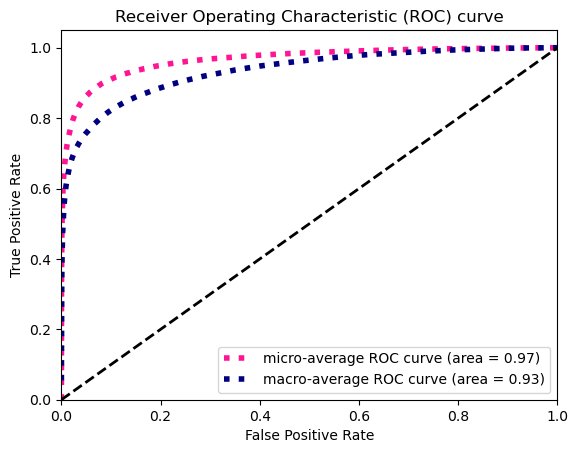

In [505]:
rep_BOW.plot_ROC_curve(y_test_mat, all_preds_test_BOW)

<a name="3.2"></a>
## 3.2 - Tfidf evaluation

In [297]:
Log_reg_tfidf = LR.MyLogisticRegression(learning_rate = 1, num_iterations = 50)
model_name = "TFIDF"

rep_tfidf = CR.Report()

In [50]:
from importlib import reload
reload(LR)

<module 'Logistic_Reg' from '/Users/sergeiakhmadulin/My Drive/Simple NLP/Logistic_Reg.py'>

In [60]:
w, p = train_model(Log_reg_tfidf, model_name, X_train_tfidf, y_train_mat, X_test_tfidf, batchsize=32, \
                   resume_training = False, save_results = True)

[[ 0.01874138  0.00630206 -0.00246977 ...  0.00479603  0.01624999
  -0.00336883]]
data stored 0
[[-0.00866407 -0.00828572 -0.00528473 ...  0.01025934  0.00666193
  -0.00513879]]
data stored 1
[[ 0.01458438 -0.0014634   0.02739878 ...  0.00166368  0.00793565
   0.01001653]]
data stored 2
[[ 0.00843229 -0.004792    0.02198047 ...  0.00262773  0.01852216
   0.00269361]]
data stored 3
[[-0.00164182  0.00609618 -0.00133547 ...  0.00911157 -0.00257869
   0.02353691]]
data stored 4
[[-0.0073738   0.00050356 -0.0003884  ...  0.00449843 -0.0042739
  -0.00800738]]
data stored 5
[[-0.00974033  0.00640593 -0.00670477 ... -0.0028785  -0.00846947
   0.01409349]]
data stored 6
[[ 2.01507899e-02 -1.09555222e-02 -1.11727710e-02 ...  4.82766831e-03
   6.90446530e-05 -2.31155496e-02]]
data stored 7
[[ 0.00575715  0.01559327  0.01247837 ... -0.01307338 -0.00447883
  -0.00894575]]
data stored 8
[[-0.0202689   0.0046734   0.00367232 ... -0.0140564  -0.01290472
  -0.00145575]]
data stored 9
[[ 0.01925929 -0.

In [299]:
all_weights_tfidf = np.load('all_weights_'+ model_name +'.npy',allow_pickle='TRUE').item()
all_preds_test_tfidf = np.load('all_preds_'+ model_name +'.npy').astype(np.float16)
all_preds_train_tfidf = np.load('all_preds_train_'+ model_name +'.npy').astype(np.float16)

In [76]:
Y_train_zero_ones_tfidf = (all_preds_test_tfidf >= 0.5).astype(int)
rep_tfidf.calc_metrics(y_test_mat, Y_train_zero_ones_tfidf)

               precision   recall   f1-score

    micro avg       0.86      0.55      0.67
    macro avg       0.71      0.41      0.51
    weighted avg    0.82      0.55      0.65



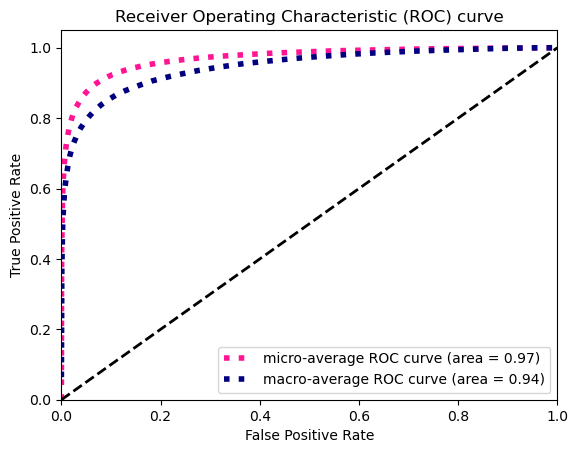

In [80]:
rep.plot_ROC_curve(y_test_mat, all_preds_test_tfidf)

<a name="3.3"></a>
## 3.3 - CBOW evaluation

In [37]:
Log_reg_cbow = LR.MyLogisticRegression(learning_rate = 1, num_iterations = 50)
model_name = "CBOW"

rep_CBOW = CR.Report()

In [411]:
w, p = train_model(Log_reg_tfidf, model_name, X_train_cbow, y_train_mat, X_test_cbow, batchsize=32, \
                   resume_training = False, save_results = True)

[[ 0.00691169  0.0035367  -0.00979832 ... -0.0013318  -0.00695445
  -0.00288814]]
data stored 0
[[ 0.00415692 -0.01329574 -0.00081818 ... -0.00491654 -0.0057894
  -0.0152766 ]]
data stored 1
[[ 1.59903566e-02 -4.48347199e-03 -7.94088757e-05 ... -2.93300294e-03
  -1.13690211e-03  2.09833674e-03]]
data stored 2
[[ 0.00108428 -0.00823013  0.00482066 ...  0.00170289 -0.02443868
   0.01428443]]
data stored 3
[[ 0.01398053  0.01764637 -0.00218093 ...  0.00978569 -0.02335522
   0.00276067]]
data stored 4
[[-0.00479951 -0.00151623  0.01641591 ... -0.01221714  0.01634912
   0.00135505]]
data stored 5
[[-0.00214523  0.00325312 -0.01025122 ...  0.00835063  0.00274783
   0.00485003]]
data stored 6
[[-0.0080777  -0.00408422  0.00871697 ...  0.00681296  0.00218065
   0.00721134]]
data stored 7
[[-0.01462386 -0.00571847  0.01331836 ...  0.00839894 -0.00910551
  -0.01688356]]
data stored 8
[[-0.00492414  0.00139713  0.00406046 ...  0.00847382  0.01683538
   0.00871918]]
data stored 9
[[ 0.01221275 -0.

In [39]:
all_weights_cbow = np.load('all_weights_'+ model_name +'.npy',allow_pickle='TRUE').item()
all_preds_test_cbow = np.load('all_preds_'+ model_name +'.npy').astype(np.float16)
all_preds_train_cbow = np.load('all_preds_train_'+ model_name +'.npy').astype(np.float16)

In [40]:
Y_test_zero_ones_cbow = (all_preds_test_cbow >= 0.5).astype(int)
rep_CBOW.calc_metrics(y_test_mat, Y_test_zero_ones_cbow)

               precision   recall   f1-score

    micro avg       0.87      0.46      0.60
    macro avg       0.67      0.32      0.41
    weighted avg    0.82      0.46      0.57



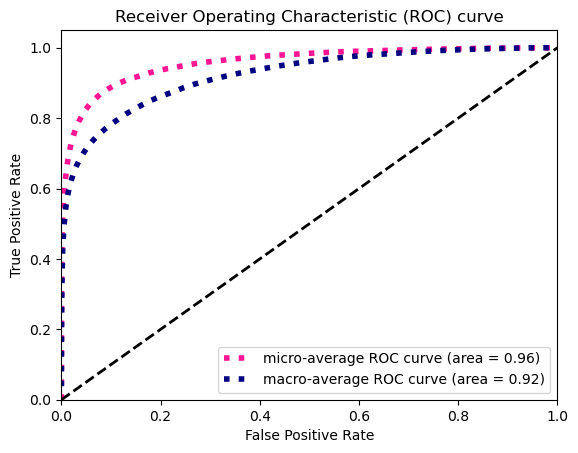

In [41]:
rep_CBOW.plot_ROC_curve(y_test_mat, all_preds_test_cbow)

<a name="4"></a>
## 4 - Most important features

Here we would like to explore which feature is tend to predict the corresponding tag. 
<br>  We will choose the most and the least valuable features for a given tag.

In [42]:
def print_words_for_tag(model, tag, index_to_words, vocab, num_features):
    """
    model: trained classifier
    tag: particular tag
    index_to_words: index_to_words dict transformation
    vocab: a list of classes names from MultiLabelBinarizer
    num_features: number of features to show
    
    return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))

    max = np.argsort(model['w'][vocab.index(tag)])[:num_features]
    min = np.argsort(model['w'][vocab.index(tag)])[-num_features:]
    top_positive_words = [index_to_words[i] for i in max]
    top_negative_words = [index_to_words[i] for i in min]
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [45]:
tags = ["sql", "python", "java", "c#", "c++"]

In [46]:
[print_words_for_tag(all_weights_cbow,tag,Ind2word_no_pad,unique_classes, 5) for tag in tags]

Tag:	sql
Top positive words:	sql, mysql, select, insert, tables
Top negative words:	server, c++, javascript, query, join

Tag:	python
Top positive words:	python, pandas, sqlalchemy, scrapy, tensorflow
Top negative words:	c#, matplotlib, r, jquery, php

Tag:	java
Top positive words:	eclipse, hibernate, javafx, maven, java
Top negative words:	c++, jquery, rails, php, spring

Tag:	c#
Top positive words:	wpf, spring, c#, gridview, nhibernate
Top negative words:	python, r, rails, vbnet, php

Tag:	c++
Top positive words:	qt, c++, opencv, boost, vector
Top negative words:	r, operator, javascript, jquery, php



[None, None, None, None, None]